# Wind Power Prediction
This notebook seeks to provide a forecast for LAke Turkana Wind Power Using the winpower lib library. 
It mainly follows these steps:
- Importation of weather data using the open weather API
- Data preparation: The imported data is read in as a dataframe and then the data prepared to a format compatible with windpowerlib
- Data from the actual wind turbines is used to model and individual wind turbine
- The windpowerlib functions are called to calculate the forecast time series for the whole farm


### Import necessary packages and modules

In [4]:
import os
import pandas as pd
import requests
import requests
import json
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize 
import config   

from windpowerlib import ModelChain, WindTurbine, create_power_curve
from windpowerlib import data as wt
import datetime as datetime
from datetime import date, timedelta

In [5]:
plt.style.use('bmh')
plt.figure(figsize=(12,7))

<Figure size 864x504 with 0 Axes>

<Figure size 864x504 with 0 Axes>

You can use the logging package to get logging messages from the windpowerlib. Change the logging level if you want more or less messages.

In [6]:
import logging
logging.getLogger().setLevel(logging.DEBUG)

### Import weather data

In order to use the windpowerlib you need to at least provide wind speed data for the time frame you want to analyze.
The function below imports example weather data from the weather.csv file provided along with the windpowerlib. The data includes wind speed at two different heights in m/s, air temperature in two different heights in K, surface roughness length in m and air pressure in Pa.

To find out which weather data in which units need to be provided to use the ModelChain or other functions of the windpowerlib see the individual function documentation.

In [7]:
#Coordinates of Lake Turkana Wind

latitude = 2.48903
longitude = 36.79317
tz ='Africa/Nairobi'

In [8]:
#subtract 12 days
end=pd.Timestamp(datetime.date.today(), tz=tz) 
start = end - timedelta(12)

## API II

In [11]:

lat = latitude
lon = longitude
urls = "https://api.openweathermap.org/data/2.5/forecast?lat=%s&lon=%s&appid=%s" % (lat, lon, config.api_key)


#https://api.weatherbit.io/v2.0/forecast/hourly

#Website Actions
jsonDatas = requests.get(urls).json()


dat_weath = pd.DataFrame(jsonDatas['list']) 
dat_weath.head()

,dt,main,weather,clouds,wind,visibility,pop,sys,dt_txt
0,1637344800,"{'temp': 304.7, 'feels_like': 303.36, 'temp_mi...","[{'id': 801, 'main': 'Clouds', 'description': ...",{'all': 11},"{'speed': 9.46, 'deg': 118, 'gust': 13.91}",10000,0,{'pod': 'n'},2021-11-19 18:00:00
1,1637355600,"{'temp': 302.77, 'feels_like': 301.94, 'temp_m...","[{'id': 801, 'main': 'Clouds', 'description': ...",{'all': 14},"{'speed': 7.36, 'deg': 113, 'gust': 11.75}",10000,0,{'pod': 'n'},2021-11-19 21:00:00
2,1637366400,"{'temp': 300.23, 'feels_like': 300.18, 'temp_m...","[{'id': 803, 'main': 'Clouds', 'description': ...",{'all': 55},"{'speed': 7.46, 'deg': 104, 'gust': 11.89}",10000,0,{'pod': 'n'},2021-11-20 00:00:00
3,1637377200,"{'temp': 298.49, 'feels_like': 298.33, 'temp_m...","[{'id': 803, 'main': 'Clouds', 'description': ...",{'all': 73},"{'speed': 10.3, 'deg': 102, 'gust': 14.37}",10000,0,{'pod': 'n'},2021-11-20 03:00:00
4,1637388000,"{'temp': 301.12, 'feels_like': 301.65, 'temp_m...","[{'id': 803, 'main': 'Clouds', 'description': ...",{'all': 82},"{'speed': 9.3, 'deg': 112, 'gust': 10.27}",10000,0,{'pod': 'd'},2021-11-20 06:00:00


In [12]:
main=dat_weath.main.apply(pd.Series)
wind=dat_weath.wind.apply(pd.Series)
weather=dat_weath.weather.apply(pd.Series)


In [13]:

dat_weath = pd.concat([dat_weath, main,wind,weather], axis=1).drop(['main','wind',
'weather','clouds','sys',0], axis=1)
dat_weath.sample(5)

,dt,visibility,pop,dt_txt,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,temp_kf,speed,deg,gust
10,1637452800,10000,0,2021-11-21 00:00:00,300.30,300.29,300.30,300.30,1006.0,1006.0,925.0,43.0,0.0,8.97,104.0,13.33
37,1637744400,10000,0,2021-11-24 09:00:00,306.41,305.19,306.41,306.41,1009.0,1009.0,929.0,28.0,0.0,8.10,105.0,7.66
9,1637442000,10000,0,2021-11-20 21:00:00,302.07,301.43,302.07,302.07,1007.0,1007.0,927.0,37.0,0.0,9.64,111.0,14.30
36,1637733600,10000,0,2021-11-24 06:00:00,302.48,302.10,302.48,302.48,1011.0,1011.0,930.0,40.0,0.0,8.21,103.0,9.21
5,1637398800,10000,0,2021-11-20 09:00:00,305.66,305.28,305.66,305.66,1008.0,1008.0,928.0,35.0,0.0,8.72,106.0,7.32


In [14]:
dat_weath.columns

Index(['dt', 'visibility', 'pop', 'dt_txt', 'temp', 'feels_like', 'temp_min',
       'temp_max', 'pressure', 'sea_level', 'grnd_level', 'humidity',
       'temp_kf', 'speed', 'deg', 'gust'],
      dtype='object')

In [15]:
dat_weath.dtypes

dt              int64
visibility      int64
pop             int64
dt_txt         object
temp          float64
feels_like    float64
temp_min      float64
temp_max      float64
pressure      float64
sea_level     float64
grnd_level    float64
humidity      float64
temp_kf       float64
speed         float64
deg           float64
gust          float64
dtype: object

In [16]:
dat_weath.columns

Index(['dt', 'visibility', 'pop', 'dt_txt', 'temp', 'feels_like', 'temp_min',
       'temp_max', 'pressure', 'sea_level', 'grnd_level', 'humidity',
       'temp_kf', 'speed', 'deg', 'gust'],
      dtype='object')

In [17]:
dat_weath['temp']=dat_weath['temp']+273
dat_weath['pressure']=dat_weath['pressure']*100

dat_weath=dat_weath[['dt_txt','speed','temp', 'pressure']]

dat_weath=dat_weath.rename(columns={'speed':'wind_speed','temp':'temperature','pressure':'pressure'})

dat_weath=dat_weath.set_index('dt_txt')
dat_weath.tail(5)

,wind_speed,temperature,pressure
dt_txt,,,
2021-11-24 03:00:00,4.71,570.50,100900.0
2021-11-24 06:00:00,8.21,575.48,101100.0
2021-11-24 09:00:00,8.10,579.41,100900.0
2021-11-24 12:00:00,5.92,580.51,100500.0
2021-11-24 15:00:00,6.22,579.29,100500.0


In [18]:
dat_weath.head(5)

,wind_speed,temperature,pressure
dt_txt,,,
2021-11-19 18:00:00,9.46,577.70,100700.0
2021-11-19 21:00:00,7.36,575.77,100700.0
2021-11-20 00:00:00,7.46,573.23,100700.0
2021-11-20 03:00:00,10.30,571.49,101000.0
2021-11-20 06:00:00,9.30,574.12,101100.0


In [19]:
type(dat_weath.index)

pandas.core.indexes.base.Index

In [20]:
# height=[60,60,10,0]
# variable_name=['wind_speed','temperature','pressure']

In [21]:
# dat_weath=pd.concat([dat_weath], axis=1, keys=height)

In [22]:
dat_weath.head()

,wind_speed,temperature,pressure
dt_txt,,,
2021-11-19 18:00:00,9.46,577.70,100700.0
2021-11-19 21:00:00,7.36,575.77,100700.0
2021-11-20 00:00:00,7.46,573.23,100700.0
2021-11-20 03:00:00,10.30,571.49,101000.0
2021-11-20 06:00:00,9.30,574.12,101100.0


In [23]:
dat_weath['roughness_length']=0.001
dat_weath.head()

,wind_speed,temperature,pressure,roughness_length
dt_txt,,,,
2021-11-19 18:00:00,9.46,577.70,100700.0,0.001
2021-11-19 21:00:00,7.36,575.77,100700.0,0.001
2021-11-20 00:00:00,7.46,573.23,100700.0,0.001
2021-11-20 03:00:00,10.30,571.49,101000.0,0.001
2021-11-20 06:00:00,9.30,574.12,101100.0,0.001


In [24]:
height=[60]

In [25]:
dat_weath['height'] = 8
dat_weath = dat_weath.set_index('height', append=True).unstack('height')

In [26]:
dat_weath.head()

,wind_speed,temperature,pressure,roughness_length
height,8,8,8,8
dt_txt,,,,
2021-11-19 18:00:00,9.46,577.70,100700.0,0.001
2021-11-19 21:00:00,7.36,575.77,100700.0,0.001
2021-11-20 00:00:00,7.46,573.23,100700.0,0.001
2021-11-20 03:00:00,10.30,571.49,101000.0,0.001
2021-11-20 06:00:00,9.30,574.12,101100.0,0.001


In [27]:
# dat_weath.columns = pd.MultiIndex.from_tuples([dat_weath.columns, height])

## Wind App

There are three ways to initialize a WindTurbine object in the windpowerlib. You can either use turbine data from the OpenEnergy Database (oedb) turbine library that is provided along with the windpowerlib, as done for the 'enercon_e126', or specify your own turbine by directly providing a power (coefficient) curve, as done below for 'my_turbine', or provide your own turbine data in csv files, as done for 'my_turbine2'.

You can execute the following to get a table of all wind turbines for which power and/or power coefficient curves are provided.

In [28]:
# specification of own wind turbine (Note: power curve values and
# nominal power have to be in Watt)
my_vestas_turbine = {
    'nominal_power': 850e3,  # in W
    'hub_height': 60,  # in m
    'power_curve': pd.DataFrame(
            data={'value': [p * 1000 for p in [
                      0,1.7,30.8,77.4,139.7,211.6,294.1,438.9,578.4,668,783.6,819.4,841.8,850.4,851.9]],  # in W
                  'wind_speed': [0.0,3.0,4.0, 5.0,6.0,7.0,8.0,9.0,10.0,
                                 11.0,12.0,13.0,14.0, 15.0,16.0]})  # in m/s
    }  
# initialiss_ze WindTurbine object.
my_vestas_turbine = WindTurbine(**my_vestas_turbine)

In [29]:
my_vestas_turbine

Wind turbine: ['nominal power=850000.0 W', 'hub height=60 m', 'power_coefficient_curve=False', 'power_curve=True']

### Use the ModelChain to calculate turbine power output

The ModelChain is a class that provides all necessary steps to calculate the power output of a wind turbine. When calling the 'run_model' method, first the wind speed and density (if necessary) at hub height are calculated and then used to calculate the power output. You can either use the default methods for the calculation steps, as done for 'my_turbine', or choose different methods, as done for the 'e126'. Of course, you can also use the default methods while only changing one or two of them, as done for 'my_turbine2'.

In [31]:
#power output calculation for e126

# own specifications for ModelChain setup
modelchain_data = {
    'wind_speed_model': 'logarithmic',      # 'logarithmic' (default),
                                            # 'hellman' or
                                            # 'interpolation_extrapolation'
    'density_model': 'ideal_gas',           # 'barometric' (default), 'ideal_gas'
                                            #  or 'interpolation_extrapolation'
    'temperature_model': 'linear_gradient', # 'linear_gradient' (def.) or
                                            # 'interpolation_extrapolation'
    'power_output_model':
        'power_coefficient_curve',          # 'power_curve' (default) or
                                            # 'power_coefficient_curve'
    'density_correction': True,             # False (default) or True
    'obstacle_height': 0,                   # default: 0
    'hellman_exp': None}                    # None (default) or None

# # initialize ModelChain with own specifications and use run_model method to
# # calculate power output
# mc_e126 = ModelChain(e126, **modelchain_data).run_model(
#     weather)
# # write power output time series to WindTurbine object
# e126.power_output = mc_e126.power_output

In [32]:
# power output calculation for example_turbine
# own specification for 'power_output_model'
mc_example_turbine = ModelChain(
    my_vestas_turbine,
    wind_speed_model='hellman').run_model(dat_weath)
my_vestas_turbine.power_output = mc_example_turbine.power_output

DEBUG:root:Calculating wind speed using hellman equation.
DEBUG:root:Calculating power output using power curve.


In [33]:
my_vestas_turbine.power_output

dt_txt
2021-11-19 18:00:00    709763.103618
2021-11-19 21:00:00    415618.207507
2021-11-20 00:00:00    433008.400544
2021-11-20 03:00:00    796849.432347
2021-11-20 06:00:00    687549.774170
2021-11-20 09:00:00    620740.228035
2021-11-20 12:00:00    542122.924115
2021-11-20 15:00:00    796419.481442
2021-11-20 18:00:00    715316.435980
2021-11-20 21:00:00    734753.099247
2021-11-21 00:00:00    647642.184114
2021-11-21 03:00:00    733364.766156
2021-11-21 06:00:00    791260.070579
2021-11-21 09:00:00    835689.357983
2021-11-21 12:00:00    736141.432337
2021-11-21 15:00:00    806308.352261
2021-11-21 18:00:00    826273.673355
2021-11-21 21:00:00    697268.105803
2021-11-22 00:00:00    592762.193713
2021-11-22 03:00:00    772238.092691
2021-11-22 06:00:00    784380.856096
2021-11-22 09:00:00    814047.468554
2021-11-22 12:00:00    768073.093419
2021-11-22 15:00:00    804588.548640
2021-11-22 18:00:00    659479.044789
2021-11-22 21:00:00    520343.148513
2021-11-23 00:00:00    386054.8

### Plot results

If you have matplotlib installed you can visualize the calculated power output and used power (coefficient) curves.

In [34]:
# try to import matplotlib
logging.getLogger().setLevel(logging.WARNING)
try:
    from matplotlib import pyplot as plt
    # matplotlib inline needed in notebook to plot inline
    %matplotlib inline 
except ImportError:
    plt = None

In [35]:
my_vestas_turbine.power_output=(my_vestas_turbine.power_output)*365/10**6
my_vestas_turbine.power_output
pout=my_vestas_turbine.power_output.reset_index()

In [36]:
pout['timestamp_local']=pd.to_datetime(pout['dt_txt'])
pout.set_index('timestamp_local',inplace=True)

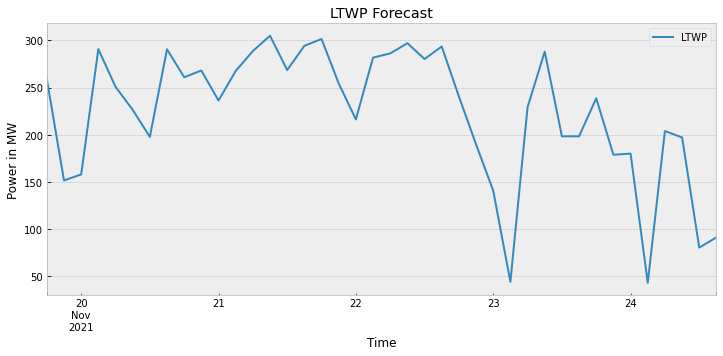

In [37]:
# plot turbine power output
plt.figure(figsize=(12,5))
if plt:
#     e126.power_output.plot(legend=True, label='Enercon E126')
#     my_turbine.power_output.plot(legend=True, label='myTurbine')
    pout['feedin_power_plant'].plot(legend=True, label='LTWP')
    plt.title('LTWP Forecast')
    plt.xlabel('Time')
    plt.ylabel('Power in MW')
    plt.show()

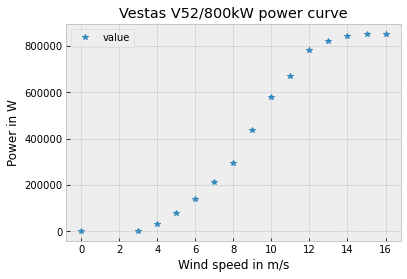

In [38]:
# plot power (coefficient) curves
if plt:

    if my_vestas_turbine.power_coefficient_curve is not None:
        my_vestas_turbine.power_coefficient_curve.plot(
            x='wind_speed', y='value', style='*',
            title='myTurbine2 power coefficient curve')
        plt.xlabel('Wind speed in m/s')
        plt.ylabel('Power in W')
        plt.show()
    if my_vestas_turbine.power_curve is not None:
        my_vestas_turbine.power_curve.plot(x='wind_speed', y='value', style='*',
                                    title='Vestas V52/800kW power curve')
        plt.xlabel('Wind speed in m/s')
        plt.ylabel('Power in W')
        plt.show()